Taking a first stab at writing a python module to do the TRUST analysis. Eventually this will go into a chris plugin

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

from nilearn import datasets, plotting
from nilearn.input_data import NiftiSpheresMasker
from nilearn.image import concat_imgs, mean_img, smooth_img, math_img, load_img
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
import nilearn.regions

import nibabel as nib

import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [9]:
# Setup paramters
N_bright_voxels = 2 # voxels in the roi that are averaged for each measurement
T1_blood = 1.818 # seconds  for SCD (Vaclavu)
print('T1 blood assumed to be ', T1_blood, 'for SCD from Vaclavu')
# T1_blood = 1.613 # seconds  original correction from Lu
Hct = 0.35

T1 blood assumed to be  1.818 for SCD from Vaclavu


In [10]:
# Ready the files
results_dir = '/home/jeff/research/SCD/derivatives/trust/'
write_fields = True
subject_str = 'sub-scd01'
ses_str = 'ses-01'

parentdir =os.path.join( '/home/jeff/research/SCD/data/', subject_str, ses_str)
outdir = os.path.join(results_dir , subject_str, ses_str)
!mkdir -p $outdir
fnamebase= subject_str + '_' +  ses_str + '_'

In [11]:
# Get list of files in the TRUST directory
import re 
import json
path2dat = os.path.join(parentdir, 'trust')
# Get list of .nii files in the source data
file_list = os.listdir(path2dat)
file_list_nii = [x for x in file_list if re.search('.nii.gz', x)]
file_list_nii.sort() # this makes certain that the "second series" is meaningful
file_list_nii

# below you make the assumption that order of the file_list is always preps for run 1 and then preps for run 2 etc.
# assert file_list_nii[0].find('prep') > file_list_nii[0].find('run'), 'Assumption violated.'

['sub-scd01_ses-01_acq-prep0_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep1_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep2_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep4_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep6_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep8_trust.nii.gz']

In [20]:
# Are there multiple runs?

# A little list counter I found here:
# (https://www.geeksforgeeks.org/python-program-to-count-duplicates-in-a-list-of-tuples/)
def count(listOfTuple): 
    count_map = {} 
    for i in listOfTuple: 
        count_map[i] = count_map.get(i, 0) +1
    print(count_map)
    return count_map # this is a dictionary

if file_list_nii[0].find('run') == -1:
    print('There was only a single run of each prep')
    idx = file_list_nii[0].find('prep') # where is prep in the string
    preps = [z[idx:idx+5] for z in file_list_nii] # make list of preps
    preps_list = list(set(preps)) # make list of unique preps
    preps_list.sort()
    preps_dict = dict.fromkeys(preps_list, None) # convert to dictionry to keep track of filename indexes below
    N_runs = 1
    runs = [1] * len(preps)
else:
    print('There was more than one run of at least one prep, and the run counts are:')
    idx = file_list_nii[0].find('prep') # where is prep in the string
    preps = [z[idx:idx+5] for z in file_list_nii] # make list of preps
    idx = file_list_nii[0].find('run')
    runs = [z[idx:idx+5] for z in file_list_nii]
    preps_list = list(set(preps)) # make list of unique preps
    preps_list.sort()
    preps_dict = dict.fromkeys(preps_list, None) # convert to dictionry to keep track of filename indexes below
    prep_runs = count(preps)
    N_runs = max(prep_runs.values())

    # Convert run list of strings to list of int
    runs = [int(sub[-1]) for sub in runs]
    
# I would like a list to index the preps, to go between prep# and filename(s)
for x in preps_list:
    idx = 0
    temp_idx = []
    for y in file_list_nii:
        if re.search(x, y) is not None:
            preps_dict[x] = temp_idx.append(int(idx))
        idx += 1
    preps_dict[x] = temp_idx

# # This is the syntax for calling this cool little  prep# and filename(s) dictionary in the future:
# for x in preps_dict['prep0']:
#     print(x)
#     print(file_list_nii[x])
    
# I would like TE vector for later
prep_vec = []
for x in preps:
    prep_vec.append(int(x[4]))
TE_vec = np.array(prep_vec) * 18e-3

There was only a single run of each prep


In [21]:
file_list_nii

['sub-scd01_ses-01_acq-prep0_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep1_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep2_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep4_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep6_trust.nii.gz',
 'sub-scd01_ses-01_acq-prep8_trust.nii.gz']

In [22]:
# This isn't a lot of data so just load it all, it is loaded in the order given in file_list_nii
temp_array = []
for x in file_list_nii:
    image = nib.load(os.path.join(path2dat , x))
    temp_array.append(image.get_fdata())

image_block = np.array(temp_array)
image_block = image_block.squeeze()
image_block = np.transpose(image_block, (0, 3, 1, 2))

# currently it is hard coded that the number acquistion in each run is 6 (3 meas, i.e. ctrl-tag pairs)
N_meas = 3
assert image_block.shape[1] == N_meas * 2, 'Measurements in the TRUST acquistion is not 3'

# Do the subtraction
sub_image_block = image_block[:,1::2,:,:] - image_block[:,::2,:,:]
sub_image_block.flags.writeable = False

In [23]:
sub_image_block.shape

(6, 3, 70, 70)

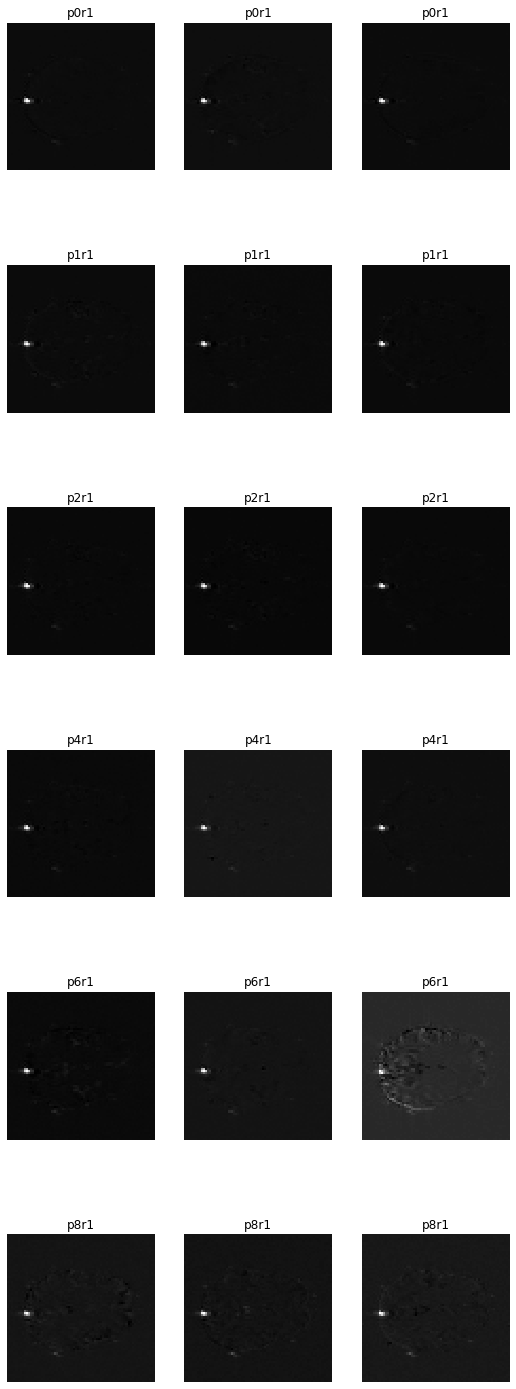

Image saved as:  /home/jeff/research/SCD/derivatives/trust/sub-scd01/ses-01/sub-scd01_ses-01_subtracted.png


In [24]:
# Make subtracted data figure

fig = plt.figure(figsize=(9, 26))
columns = N_meas
rows = len(preps)

# ax enables access to manipulate each of subplots
ax = []
ind = 1

for i in range(rows):
    for j in range(columns):
        img = sub_image_block[i,j,:,:].squeeze()
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, ind) )
        ax[-1].set_title('p' + preps[i][-1] + 'r' + str(runs[i]))  # set title
        ax[-1].axis('off')
        plt.gray()
        plt.imshow(img)
        ind += 1
        
plt.savefig(os.path.join(outdir, fnamebase + 'subtracted.png'))
plt.show()  # finally, render the plot
print('Image saved as: ', os.path.join(outdir, fnamebase + 'subtracted.png'))


Using matplotlib backend: Qt5Agg
ROI saved to nifti:  /home/jeff/research/SCD/derivatives/trust/sub-scd01/ses-01/sub-scd01_ses-01_ROI.nii.gz


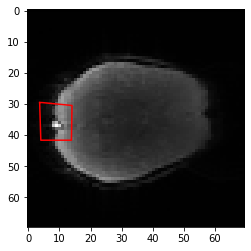

In [26]:
# Draw ROI around SSS if an ROI doesn't already exist

ROI_path = os.path.join(outdir, fnamebase + 'ROI.nii.gz');

if os.path.exists(ROI_path):
    img = nib.load(ROI_path)
    sss_roi_bin = img.get_fdata().squeeze() == 1
    print('ROI loaded from: ', ROI_path)
    plt.imshow(sss_roi_bin)

else:
    # for this to work remotely the orginal ssh session with -X needs to be open
    %matplotlib
    plt.imshow(image_block[1,1,:,:])

    from roipoly import RoiPoly
    sss_roi = RoiPoly(color='r') # draw new ROI in red color
    mask = sss_roi.get_mask(image_block[0,0,:,:]) # create binary signal mask
    %matplotlib inline
    plt.imshow(image_block[1,1,:,:]) 
    sss_roi.display_roi()
    sss_roi_bin = sss_roi.get_mask(sub_image_block[1,1,:,:])
    
    # Save the SSS_mask as a nifti for future viewing
    img = nib.load( os.path.join(path2dat, file_list_nii[1]) )
    aff = img.header.get_qform()
    img = nib.Nifti1Image(sss_roi_bin.astype('int16'), aff)
    nib.save(img, ROI_path)
    print('ROI saved to nifti: ', ROI_path)

In [27]:
# Create vectors of mean three brightest voxels and TEs
%matplotlib inline

# This function takes in a masked image and gives you back the three brightest voxels,
# their indicies, and a bright voxel mask
# Note: for multiple max voxels of identical SI, "np.argmax: In case of multiple occurrences of the maximum values, the indices corresponding to the first occurrence are returned."
def findbrightvox(image, N_bright_voxels = 3):
    voxel_vals = []
    val_indicies = []
    brtvox_mask = np.zeros(image.shape, dtype=np.bool)
    for x in range(N_bright_voxels):
        ind = np.unravel_index(np.argmax(image, axis=None), image.shape) # find the index of the max val in the image
        val_indicies.append(ind)
        voxel_vals.append(image[ind]) # record the max val
        image[ind] = 0 # eliminate this max vox for the next iteration
        brtvox_mask[ind] = True # create the bright voxel mask
    return voxel_vals, val_indicies, brtvox_mask

# now get the three brightest voxels for each subtracted acquisition
# sub_image_block.shape => (10, 3, 70, 70)
voxel_vals = np.zeros([sub_image_block.shape[0],sub_image_block.shape[1],N_bright_voxels])
brtvox_mask = sub_image_block.copy()
for i in range(sub_image_block.shape[0]):
    for j in range(sub_image_block.shape[1]):
        [v, ind, m] = findbrightvox(sss_roi_bin*sub_image_block[i,j,:,:], N_bright_voxels)
        voxel_vals[i,j,:] = v
        brtvox_mask[i,j,:,:] = m

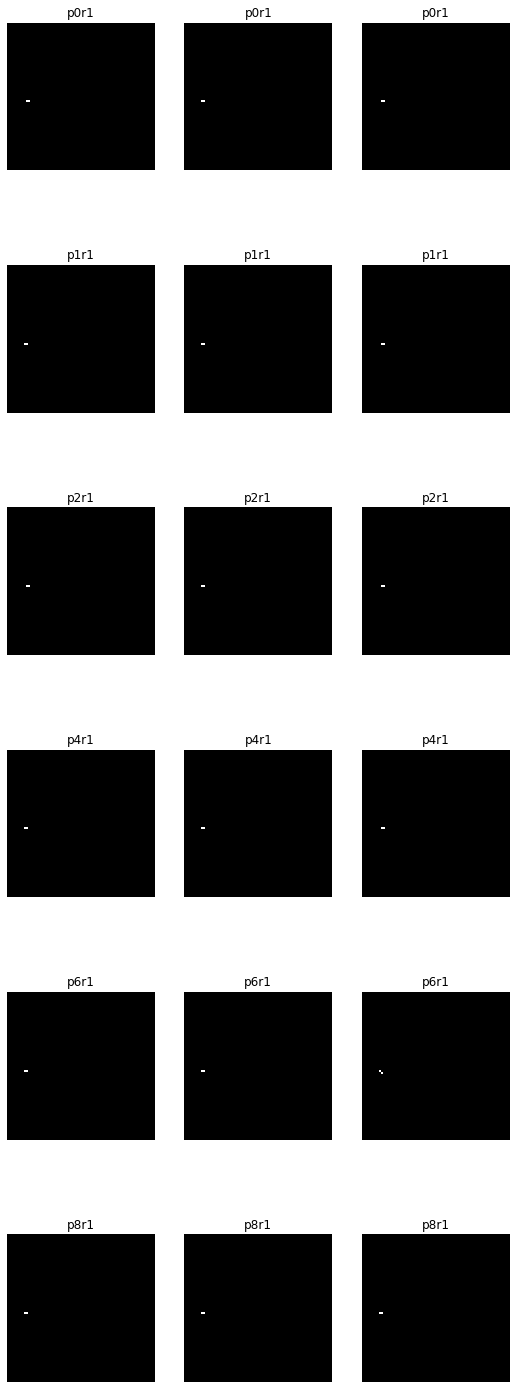

Image saved as:  /home/jeff/research/SCD/derivatives/trust/sub-scd01/ses-01/sub-scd01_ses-01_brtvoxmask.png


In [28]:
# Make bright voxel mask figure

fig = plt.figure(figsize=(9, 26))
columns = N_meas
rows = len(preps)

# ax enables access to manipulate each of subplots
ax = []
ind = 1

for i in range(rows):
    for j in range(columns):
        img = brtvox_mask[i,j,:,:].squeeze()
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, ind) )
        ax[-1].set_title('p' + preps[i][-1] + 'r' + str(runs[i]))  # set title
        ax[-1].axis('off')
        plt.gray()
        plt.imshow(img)
        ind += 1
        
plt.savefig(os.path.join(outdir, fnamebase + 'brtvoxmask.png'))
plt.show()  # finally, render the plot
print('Image saved as: ', os.path.join(outdir, fnamebase + 'brtvoxmask.png'))


Text(0, 0.5, 'Signal intensity')

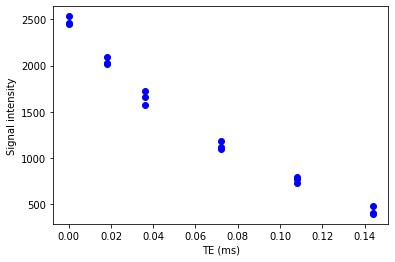

In [29]:
# Plot mean of three brightest voxels vs TE
fig, ax = plt.subplots()
ax.plot(TE_vec, np.mean(voxel_vals, axis = 2), 'bo')
plt.xlabel('TE (ms)')
plt.ylabel('Signal intensity')

In [30]:
# Manual motion removal
motion_select = np.zeros([len(preps), N_meas])
# motion_select[0,2]=1
# motion_select[1,2]=1
# motion_select[3,1]=1
# motion_select[4,0]=1
# motion_select[4,2]=1
# motion_select[5,0]=1
# motion_select[8,0]=1
print('motion_select =\n', motion_select)

motion_select =
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [31]:
np.mean(voxel_vals, axis = 2).shape, motion_select.shape, TE_vec.shape

((6, 3), (6, 3), (6,))

In [32]:
np.tile(TE_vec, (N_meas, 1)).transpose()[motion_select == 0]

array([0.   , 0.   , 0.   , 0.018, 0.018, 0.018, 0.036, 0.036, 0.036,
       0.072, 0.072, 0.072, 0.108, 0.108, 0.108, 0.144, 0.144, 0.144])

SDR =  0.06916417104848888


Text(0.5, 0, 'TE')

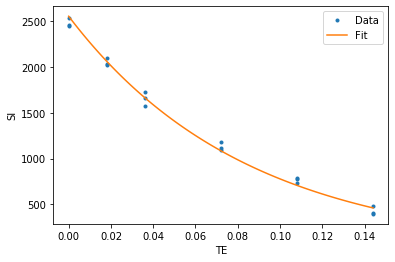

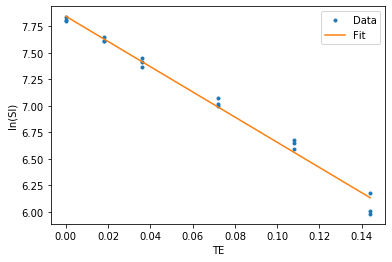

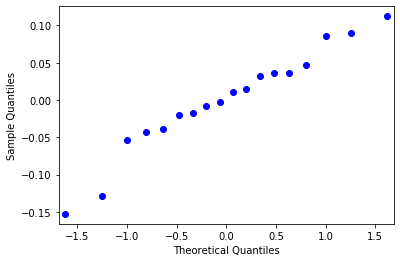

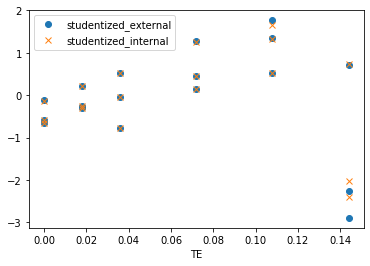

In [33]:
# Do the fitting
y = np.mean(voxel_vals, axis = 2)[motion_select == 0] # average bright voxels
x = np.tile(TE_vec, (N_meas, 1)).transpose()[motion_select == 0] # TE_vec reshaped for the data above

d = {'TE': np.tile(TE_vec, (N_meas, 1)).transpose()[motion_select == 0],
   'SI': np.mean(voxel_vals, axis = 2)[motion_select == 0],
   'ln_SI': np.log(np.mean(voxel_vals, axis = 2)[motion_select == 0])}
df = pd.DataFrame(data=d)

# This is overkill for a simple linear regression, but good practice at a universal way to do regression analysis
reg = smf.ols('ln_SI ~ TE', data = df)
res = reg.fit()

# standard deviation of residuals (SDR)
SSE = res.ssr
SDR = np.sqrt(SSE/(len(x)-1))
print('SDR = ', SDR)

# T2 confidence intervals
res_ci = res.conf_int().loc['TE'].tolist()
T2_ci = [res_ci[0]**-1]
T2_ci.append(res_ci[1]**-1)

# plot of data and fit
df_pred = pd.DataFrame(data = {'TE': np.linspace(min(x), max(x), 100)})
df_pred['ln_SI'] = res.predict(df_pred.TE) # NOTE: the predict method must operate on a df once the formula api is used
df_pred['SI'] = np.exp(df_pred.ln_SI)

fig, ax = plt.subplots()
ax.plot(df.TE,df.SI,'.', label="Data")
ax.plot(df_pred.TE,df_pred.SI,'-', label="Fit")
ax.legend(loc = 'best')
plt.ylabel('SI')
plt.xlabel('TE')

# plot of linearized data and fit
fig, ax = plt.subplots()
ax.plot(df.TE, df.ln_SI, '.', label="Data")
ax.plot(df_pred.TE, df_pred.ln_SI, '-', label="Fit")
ax.legend(loc = 'best')
plt.ylabel('ln(SI)')
plt.xlabel('TE')

# normal residuals?
sm.qqplot(res.resid)

# plot of studentized residuals
infl = res.get_influence()
plt.figure()
plt.plot(df.TE, infl.resid_studentized_external, 'o', label='studentized_external')
plt.plot(df.TE, infl.resid_studentized_internal, 'x', label='studentized_internal')
plt.legend(loc = 'best')
plt.xlabel('TE')



In [34]:
# Generate corrected C, corrected T2 and SO2 for Hct
C = -1/res.params.TE
T2 = (T1_blood**-1 - res.params.TE)**-1
print('C =', C, 'T2 =', T2)

C = 0.08413690365036496 T2 = 0.08041529005762851


In [35]:
import T2toSvO2
SvO2 = T2toSvO2.T2toSvO2(T2, Hct, tCPMG = 10, model = 'SCD')
print('SO2 =', float(SvO2))

SO2 = 0.6909589477977958


In [37]:
# write results
import csv  
    
# field names  
fields = ['subject', 'T2', 'Hct', 'SvO2', 'T2CI-', 'T2CI+', 'SDR']  
    
# data rows of csv file  
row = [fnamebase, T2, Hct, float(SvO2), T2_ci[0], T2_ci[1], float(SDR)]
    
# name of csv file  
filename = os.path.join(results_dir, 'TRUST_analysis_results.csv')
    
# writing to csv file  
with open(filename, 'w', newline='') as file:  
    # creating a csv writer object  
    csvwriter = csv.writer(file)  
    
    if write_fields:
        # writing the fields  
        csvwriter.writerow(fields)  
        
    # writing the data rows  
    csvwriter.writerow(row) 

# Programming Notes

In [21]:
# np.unravel_index hint
# note that np is like C for indexing
#   | 0      1      2      3
# --+------------------------
# 0 | 0      1      2      3
# 1 | 4      5      6      7
# 2 | 8      9     10     11

np.unravel_index(6, (3, 4))

(1, 2)